In [188]:
!pip install git+https://github.com/lnccbrown/HSSM.git

  Cloning https://github.com/lnccbrown/HSSM.git to /tmp/pip-req-build-18t3h1ab
  Running command git clone --filter=blob:none --quiet https://github.com/lnccbrown/HSSM.git /tmp/pip-req-build-18t3h1ab
  Resolved https://github.com/lnccbrown/HSSM.git to commit 19b24538a20938ffc4c8b0bf88ca35d6d51b4196
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [189]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import hssm
import hssm.plotting
hssm.set_floatX("float32")
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
exp_data = pd.read_csv('experiment_data.csv')
exp_data

Setting PyTensor floatX type to float32.


INFO:hssm:Setting PyTensor floatX type to float32.


Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


INFO:hssm:Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


,rt,key_press,correct,coherent_movement_direction,coherence_movement,opposite_coherence_movement,coherent_orientation,coherence_orientation,task_type,task_transition,congruency,experiment_type
0,982,j,True,0,50,26,0,24,or,NaN,congruent,-1
1,1280,f,True,180,61,33,0,6,mov,switch,incongruent,-1
2,1674,j,False,180,60,27,180,13,or,switch,congruent,-1
3,1635,j,True,180,75,15,0,10,or,repetition,incongruent,-1
4,-1,NaN,False,180,64,15,180,21,or,repetition,congruent,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
155,1278,f,True,0,50,44,0,6,mov,switch,congruent,2
156,944,j,True,0,73,2,0,25,or,switch,congruent,2
157,1324,f,True,0,67,24,0,9,mov,switch,congruent,2
158,829,f,False,0,53,24,0,23,mov,repetition,incongruent,2


## **Data Preparation**

In [190]:
exp_data_req = exp_data[exp_data['experiment_type']!=-1]
exp_data_req

,rt,key_press,correct,coherent_movement_direction,coherence_movement,opposite_coherence_movement,coherent_orientation,coherence_orientation,task_type,task_transition,congruency,experiment_type
16,1191,f,True,0,57,42,180,1,or,NaN,incongruent,0
17,1094,j,False,180,59,24,180,17,or,repetition,congruent,0
18,1621,j,True,0,60,19,0,21,or,repetition,congruent,0
19,1564,j,True,0,73,10,0,17,or,repetition,congruent,0
20,1157,j,True,0,64,13,0,23,mov,switch,congruent,0
...,...,...,...,...,...,...,...,...,...,...,...,...
155,1278,f,True,0,50,44,0,6,mov,switch,congruent,2
156,944,j,True,0,73,2,0,25,or,switch,congruent,2
157,1324,f,True,0,67,24,0,9,mov,switch,congruent,2
158,829,f,False,0,53,24,0,23,mov,repetition,incongruent,2


In [191]:
exp_data_req['left_right'] = exp_data_req['key_press'].replace(['f','j', np.nan],[1,-1, 0]).astype(int)

In [192]:
# if len(exp_data_req[exp_data_req['key_press'].isna() == True]) <= round((len(exp_data_req)*2/100),0):
#   exp_data_req = exp_data_req[exp_data_req['key_press'].isna() == False]

In [193]:
exp_data_req.drop(['coherent_movement_direction', 'coherent_orientation', 'key_press'], axis = 1, inplace = True)
exp_data_req.rename({'correct':'response'},axis=1, inplace = True)
exp_data_req['response'] = exp_data_req['response'].replace([True,False],[1,-1])
exp_data_req['rt'] = exp_data_req['rt']/1000
exp_data_req['coherence_movement'] = exp_data_req['coherence_movement']/100
exp_data_req['opposite_coherence_movement'] = exp_data_req['opposite_coherence_movement']/100
exp_data_req['coherence_orientation'] = exp_data_req['coherence_orientation']/100
exp_data_req

,rt,response,coherence_movement,opposite_coherence_movement,coherence_orientation,task_type,task_transition,congruency,experiment_type,left_right
16,1.191,1,0.57,0.42,0.01,or,NaN,incongruent,0,1
17,1.094,-1,0.59,0.24,0.17,or,repetition,congruent,0,-1
18,1.621,1,0.60,0.19,0.21,or,repetition,congruent,0,-1
19,1.564,1,0.73,0.10,0.17,or,repetition,congruent,0,-1
20,1.157,1,0.64,0.13,0.23,mov,switch,congruent,0,-1
...,...,...,...,...,...,...,...,...,...,...
155,1.278,1,0.50,0.44,0.06,mov,switch,congruent,2,1
156,0.944,1,0.73,0.02,0.25,or,switch,congruent,2,-1
157,1.324,1,0.67,0.24,0.09,mov,switch,congruent,2,1
158,0.829,-1,0.53,0.24,0.23,mov,repetition,incongruent,2,1


In [194]:
label_encoding_column_list = []

for column in exp_data_req.columns:
    if not pd.api.types.is_numeric_dtype(exp_data_req[column]) or pd.api.types.is_bool_dtype(exp_data_req[column]):
        label_encoding_column_list.append(column)
label_encoding_column_list

['task_type', 'task_transition', 'congruency']

In [195]:
for i in label_encoding_column_list:
  label_encoder = LabelEncoder()
  exp_data_req[i]= label_encoder.fit_transform(exp_data_req[i])
exp_data_req

,rt,response,coherence_movement,opposite_coherence_movement,coherence_orientation,task_type,task_transition,congruency,experiment_type,left_right
16,1.191,1,0.57,0.42,0.01,1,2,1,0,1
17,1.094,-1,0.59,0.24,0.17,1,0,0,0,-1
18,1.621,1,0.60,0.19,0.21,1,0,0,0,-1
19,1.564,1,0.73,0.10,0.17,1,0,0,0,-1
20,1.157,1,0.64,0.13,0.23,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...
155,1.278,1,0.50,0.44,0.06,0,1,0,2,1
156,0.944,1,0.73,0.02,0.25,1,1,0,2,-1
157,1.324,1,0.67,0.24,0.09,0,1,0,2,1
158,0.829,-1,0.53,0.24,0.23,0,0,1,2,1


In [196]:
exp_data_req['trial_no_exp_type'] = 1
exp_data_req['trial_no_exp_type'] = exp_data_req.groupby(['experiment_type'])['trial_no_exp_type'].cumsum()
exp_data_req['confidence_exp_type'] = exp_data_req.groupby(['experiment_type'])['response'].cumsum()
exp_data_req['confidence_exp_type'] = exp_data_req['confidence_exp_type']/exp_data_req['trial_no_exp_type']
exp_data_req['confidence_exp_type'] = exp_data_req['confidence_exp_type'].round(2)

In [197]:
# Define a custom function to calculate cumulative sum until a zero appears
def cumulative_sum_until_zero(series):
    cum_sum = 0
    cum_sum_list = []
    for value in series:
        if value == 0:
            cum_sum = 0
        else:
            cum_sum += value
        cum_sum_list.append(cum_sum)
    return cum_sum_list

exp_data_req['win_loss'] = exp_data_req['response'].apply(lambda x: 1 if x == 1 else 0)
exp_data_req['loss_win'] = exp_data_req['response'].apply(lambda x: 0 if x == 1 else 1)

exp_data_req['win_streak_exp_type'] = exp_data_req.groupby(['experiment_type'])['win_loss'].transform(cumulative_sum_until_zero)
exp_data_req['loss_streak_exp_type'] = exp_data_req.groupby(['experiment_type'])['loss_win'].transform(cumulative_sum_until_zero)

In [198]:
exp_data_req['accuracy_exp_type'] = exp_data_req.groupby(['experiment_type'])['win_loss'].cumsum()
exp_data_req['accuracy_exp_type'] = exp_data_req['accuracy_exp_type']/exp_data_req['trial_no_exp_type']
exp_data_req['accuracy_exp_type'] = exp_data_req['accuracy_exp_type'].round(2)
exp_data_req

,rt,response,coherence_movement,opposite_coherence_movement,coherence_orientation,task_type,task_transition,congruency,experiment_type,left_right,trial_no_exp_type,confidence_exp_type,win_loss,loss_win,win_streak_exp_type,loss_streak_exp_type,accuracy_exp_type
16,1.191,1,0.57,0.42,0.01,1,2,1,0,1,1,1.00,1,0,1,0,1.00
17,1.094,-1,0.59,0.24,0.17,1,0,0,0,-1,2,0.00,0,1,0,1,0.50
18,1.621,1,0.60,0.19,0.21,1,0,0,0,-1,3,0.33,1,0,1,0,0.67
19,1.564,1,0.73,0.10,0.17,1,0,0,0,-1,4,0.50,1,0,2,0,0.75
20,1.157,1,0.64,0.13,0.23,0,1,0,0,-1,5,0.60,1,0,3,0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,1.278,1,0.50,0.44,0.06,0,1,0,2,1,44,0.09,1,0,1,0,0.55
156,0.944,1,0.73,0.02,0.25,1,1,0,2,-1,45,0.11,1,0,2,0,0.56
157,1.324,1,0.67,0.24,0.09,0,1,0,2,1,46,0.13,1,0,3,0,0.57
158,0.829,-1,0.53,0.24,0.23,0,0,1,2,1,47,0.11,0,1,0,1,0.55


In [199]:
# exp_data_req['overall_trial_no'] = 1
# exp_data_req['overall_trial_no'] = exp_data_req['overall_trial_no'].cumsum()
# exp_data_req['overall_accuracy'] = exp_data_req['win_loss'].cumsum()
# exp_data_req['overall_accuracy'] = exp_data_req['overall_accuracy']/exp_data_req['overall_trial_no']
# exp_data_req['overall_confidence'] = exp_data_req['response'].cumsum()
# exp_data_req['overall_confidence'] = exp_data_req['overall_confidence']/exp_data_req['overall_trial_no']

# exp_data_req['overall_accuracy'] = exp_data_req['overall_accuracy'].round(2)
# exp_data_req['overall_confidence'] = exp_data_req['overall_confidence'].round(2)
# exp_data_req

for col in exp_data_req.columns:
    if exp_data_req[col].dtype == 'int':
        exp_data_req[col] = exp_data_req[col].astype('float64')
exp_data_req.dtypes

rt                             float64
response                       float64
coherence_movement             float64
opposite_coherence_movement    float64
coherence_orientation          float64
task_type                      float64
task_transition                float64
congruency                     float64
experiment_type                float64
left_right                     float64
trial_no_exp_type              float64
confidence_exp_type            float64
win_loss                       float64
loss_win                       float64
win_streak_exp_type            float64
loss_streak_exp_type           float64
accuracy_exp_type              float64
dtype: object

Dividing the dataset basis Experiment type

In [200]:
exp_type_1 = exp_data_req[exp_data_req['experiment_type']==0]
exp_type_2 = exp_data_req[exp_data_req['experiment_type']==1]
exp_type_3 = exp_data_req[exp_data_req['experiment_type']==2]

exp_type_1.drop(['experiment_type'], axis = 1, inplace = True)
exp_type_2.drop(['experiment_type'], axis = 1, inplace = True)
exp_type_3.drop(['experiment_type'], axis = 1, inplace = True)

Creating correlation matrices and scatter plots to check the relationship between the variables present

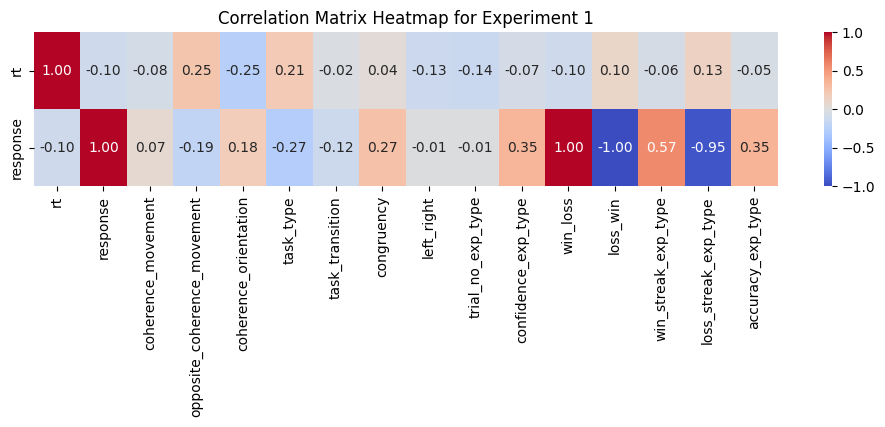

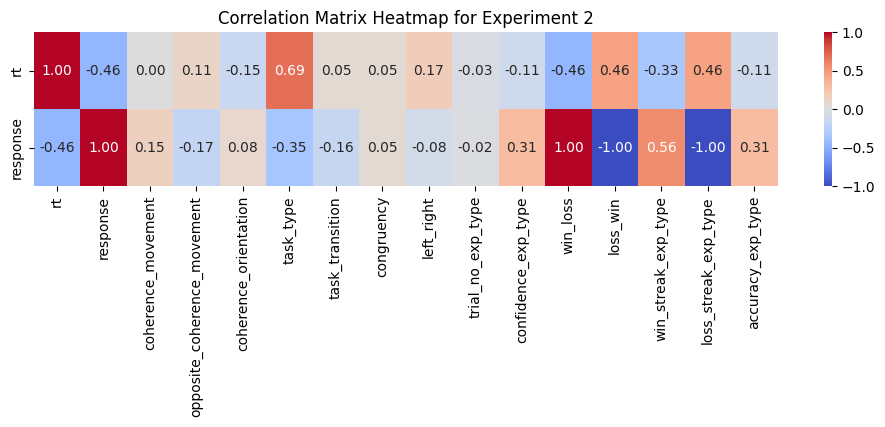

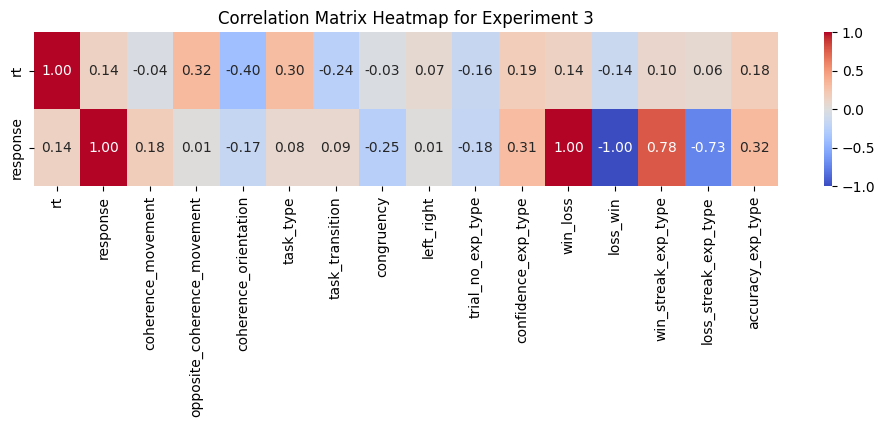

In [201]:
exp_data_list = [exp_type_1, exp_type_2, exp_type_3]
j = 1

for df in exp_data_list:
  # Calculate correlation matrix
  correlation_matrix = df.corr()
  # Plot heatmap
  plt.figure(figsize=(12, 2))
  sns.heatmap(correlation_matrix[correlation_matrix.index.isin(['rt', 'response'])], annot=True, cmap='coolwarm', fmt=".2f")
  plt.title('Correlation Matrix Heatmap for Experiment {}'.format(j))
  plt.show()
  j+=1

Comparing reaction time with the other variables in Experiment 0


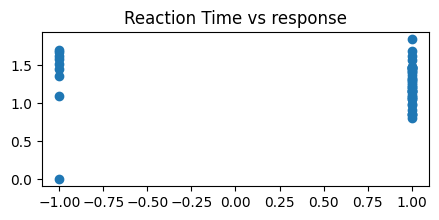

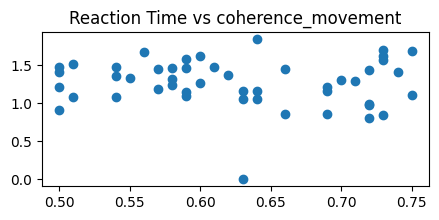

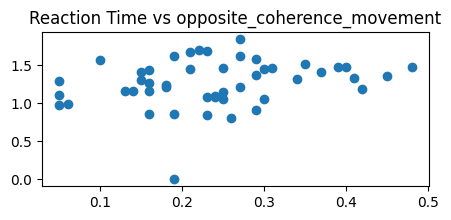

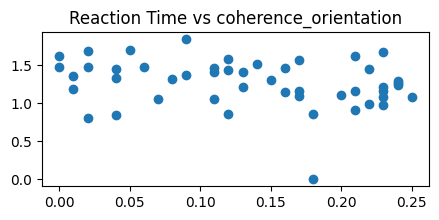

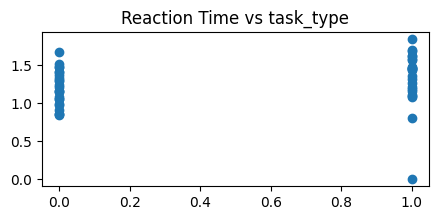

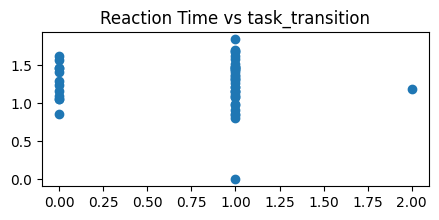

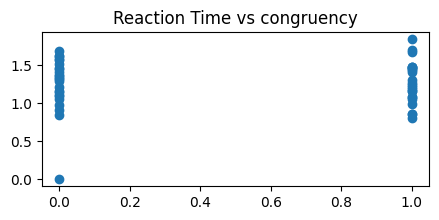

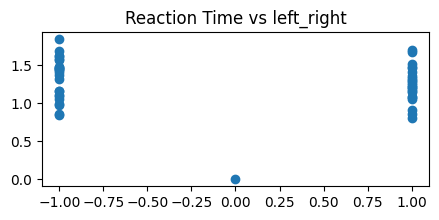

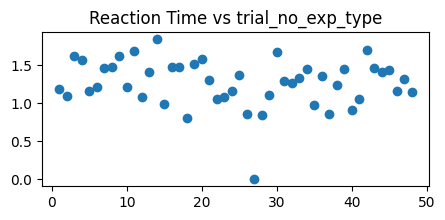

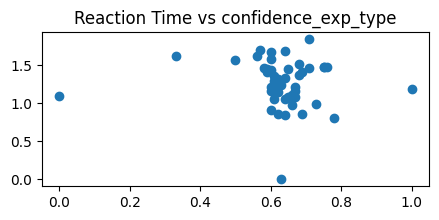

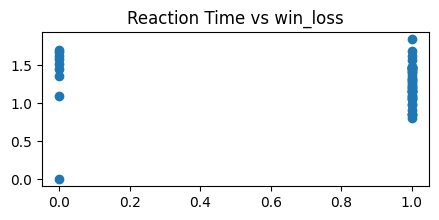

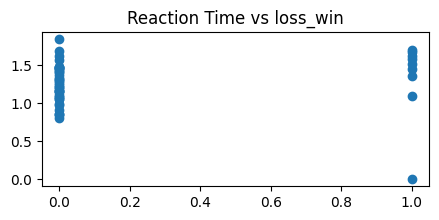

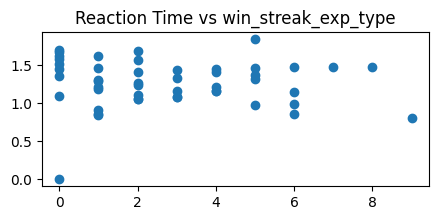

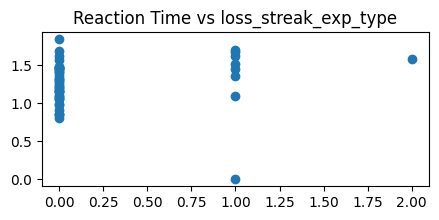

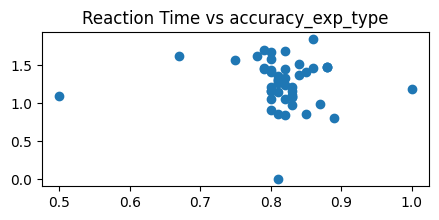

Comparing reaction time with the other variables in Experiment 1


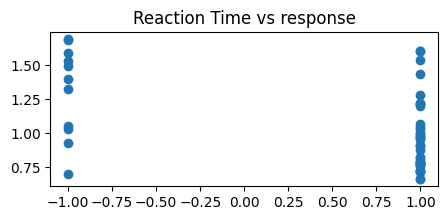

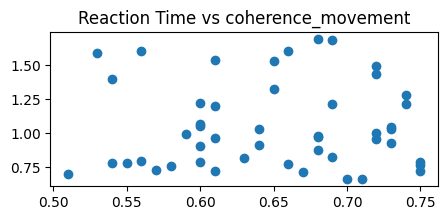

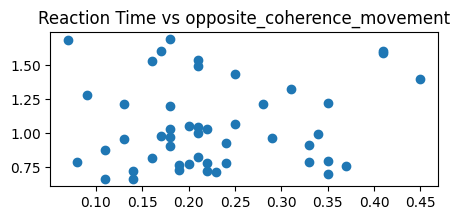

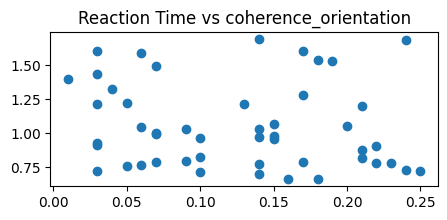

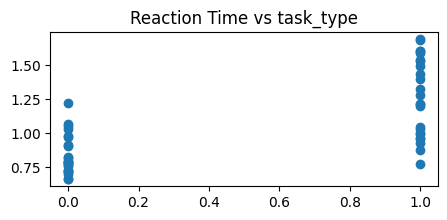

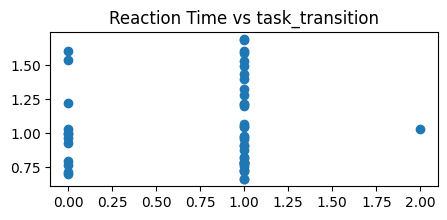

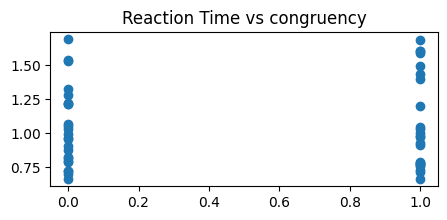

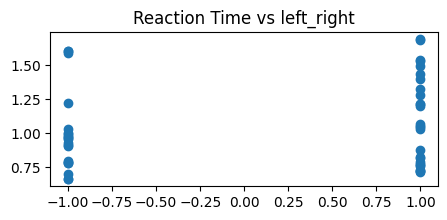

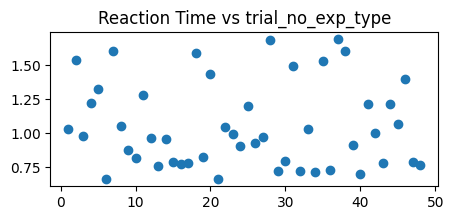

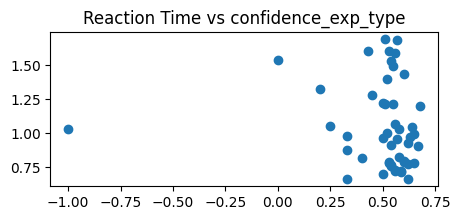

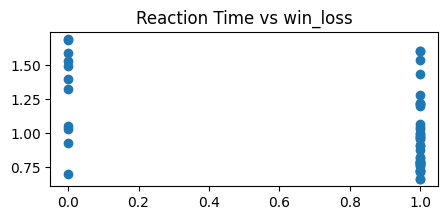

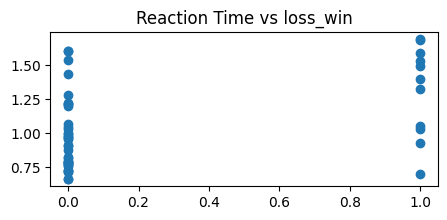

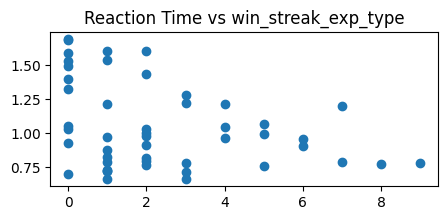

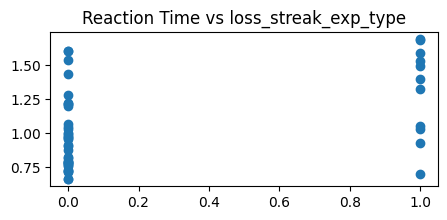

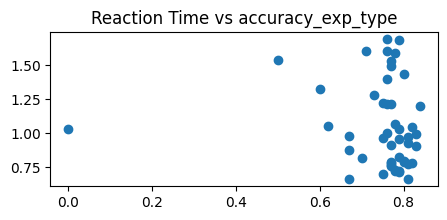

Comparing reaction time with the other variables in Experiment 2


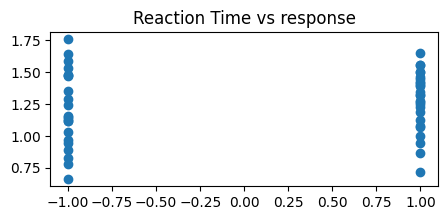

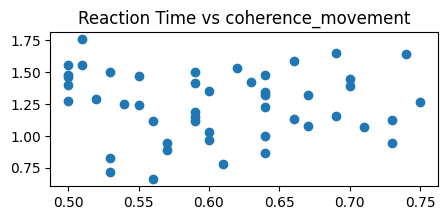

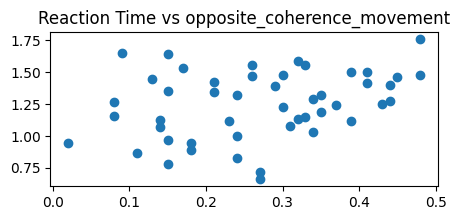

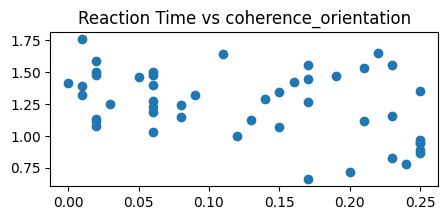

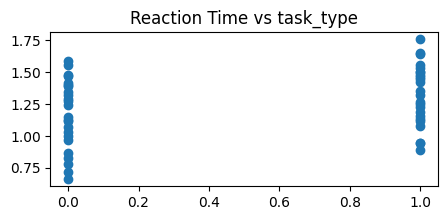

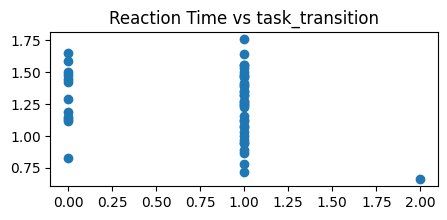

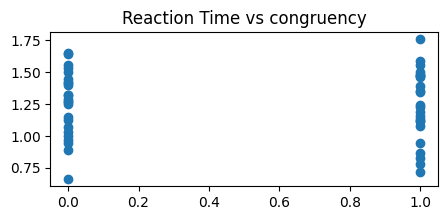

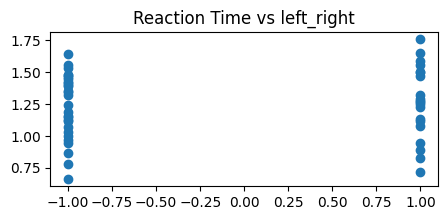

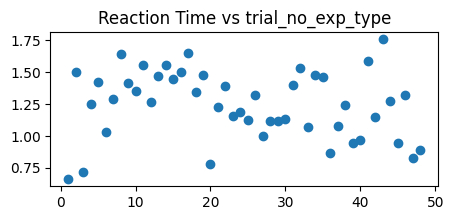

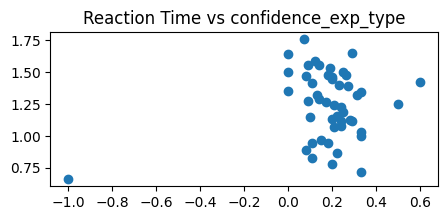

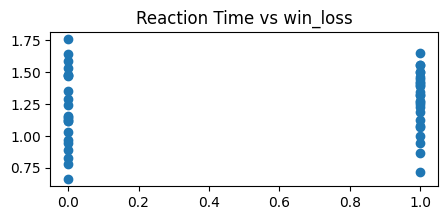

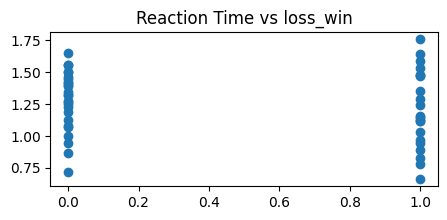

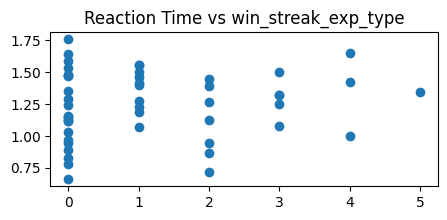

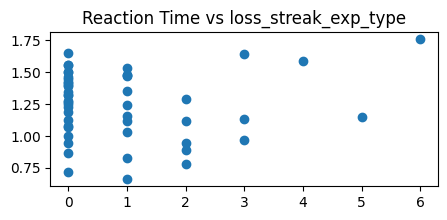

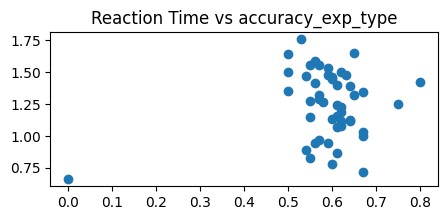

In [202]:
j = 0
for df in exp_data_list:
  print('Comparing reaction time with the other variables in Experiment {}'.format(j))
  j+=1
  for i in df.columns:
    if i!= 'rt':
      plt.figure(figsize=(5, 2))
      plt.scatter(df[i], df['rt'])
      plt.title('Reaction Time'+' vs '+str(i))
      plt.show()

In [203]:
req_exp_type_1 = exp_type_1[['rt', 'response', 'coherence_movement',
       'coherence_orientation', 'task_type', 'task_transition', 'congruency',
       'left_right', 'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]
req_exp_type_2 = exp_type_2[['rt', 'response', 'coherence_movement',
       'coherence_orientation', 'task_type', 'task_transition', 'congruency',
       'left_right', 'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]
req_exp_type_3 = exp_type_3[['rt', 'response', 'coherence_movement',
       'coherence_orientation', 'task_type', 'task_transition', 'congruency',
       'left_right', 'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]

In [204]:
initial_ddm_exp_type_1 = hssm.HSSM(
    data=req_exp_type_1[['rt', 'response']],
)

initial_ddm_exp_type_2 = hssm.HSSM(
    data=req_exp_type_2[['rt', 'response']],
)

initial_ddm_exp_type_3 = hssm.HSSM(
    data=req_exp_type_3[['rt', 'response']],
)

In [239]:
# Fit both models using MCMC

initial_ddm_exp_type_1_model_inference = initial_ddm_exp_type_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

initial_ddm_exp_type_2_model_inference = initial_ddm_exp_type_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

initial_ddm_exp_type_3_model_inference = initial_ddm_exp_type_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

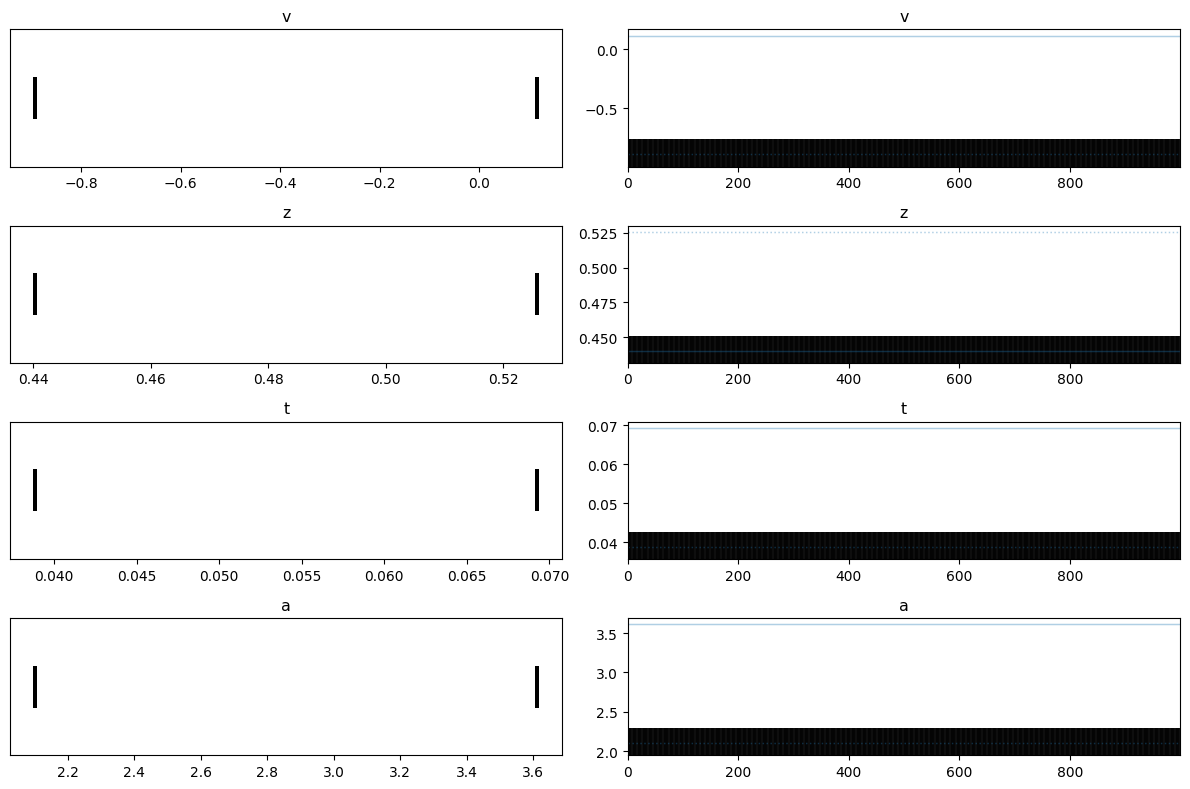

In [244]:
initial_ddm_exp_type_1.plot_trace()

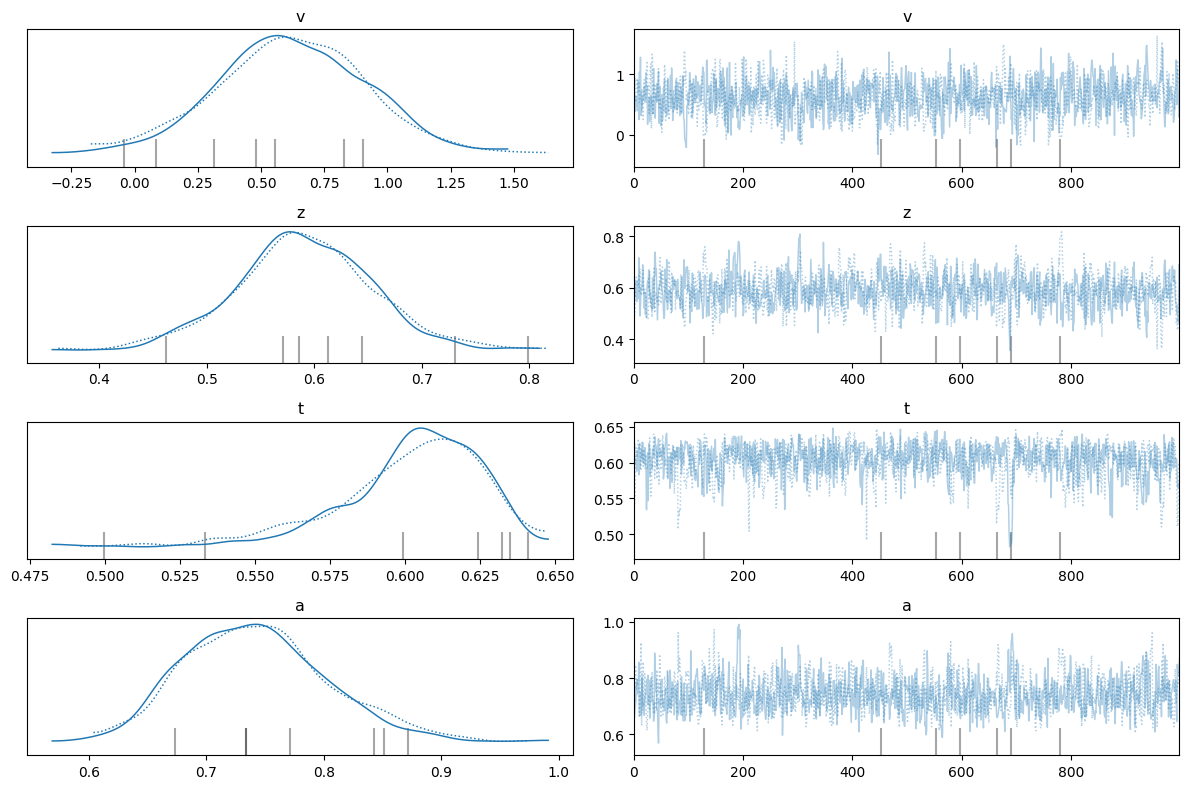

In [243]:
initial_ddm_exp_type_2.plot_trace()

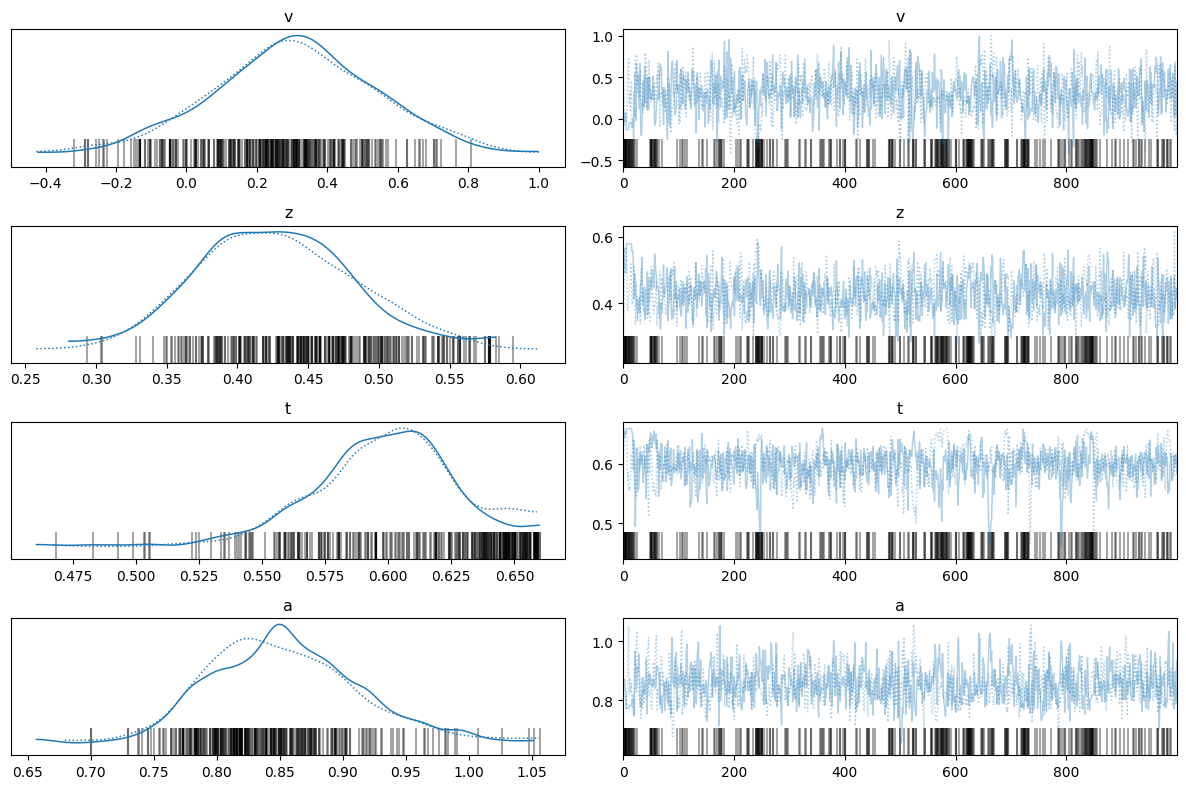

In [245]:
initial_ddm_exp_type_3.plot_trace()

## **Model Comparison using the different phases of the experiment considering all the variables**

*The below code consists of the modeling done by taking all the parameters into consideration and comparing the models to see the better ones. The effect of the factors used might change basis the effects of these factors on the participant.*

**Basis the relationship , correlation of the factors and some assumptions, we model the HSSM model for the 3 different experiments by considering different dependencies for v and a.**

In [229]:
v_formula = "v ~ C(task_transition) + (coherence_movement * coherence_orientation) + (win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type)"
a_formula = "a ~ C(left_right) + C(task_type) + C(congruency) + trial_no_exp_type"

In [230]:
ddm_exp_type_1 = hssm.HSSM(
    data=req_exp_type_1,
    include=[
        {
            "name": "v",
            "formula": v_formula,
        },
        {
            "name": "a",
            "formula": a_formula,
        }
    ],
)

ddm_exp_type_2 = hssm.HSSM(
    data=req_exp_type_2,
    include=[
        {
            "name": "v",
            "formula": v_formula,
        },
        {
            "name": "a",
            "formula": a_formula,
        }
    ],
)

ddm_exp_type_3 = hssm.HSSM(
    data=req_exp_type_3,
    include=[
        {
            "name": "v",
            "formula": v_formula,
        },
        {
            "name": "a",
            "formula": a_formula,
        }
    ],
)

In [234]:
# Fit both models using MCMC

ddm_exp_type_1_model_inference = ddm_exp_type_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

ddm_exp_type_2_model_inference = ddm_exp_type_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

ddm_exp_type_3_model_inference = ddm_exp_type_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison = az.compare(
    {
        "Experiment Type 1": ddm_exp_type_1.traces,
        "Experiment Type 2": ddm_exp_type_2.traces,
        "Experiment Type 3": ddm_exp_type_3.traces,
    }
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [235]:
model_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 3,0,-1752.185755,191.772001,0.000000,0.496403,213.290041,0.000000,True,log
Experiment Type 2,1,-1765.878785,198.625637,13.693029,0.503597,211.128129,416.034998,True,log
Experiment Type 1,2,-2902.531550,2229.562753,1150.345795,0.000000,116.001058,271.105159,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

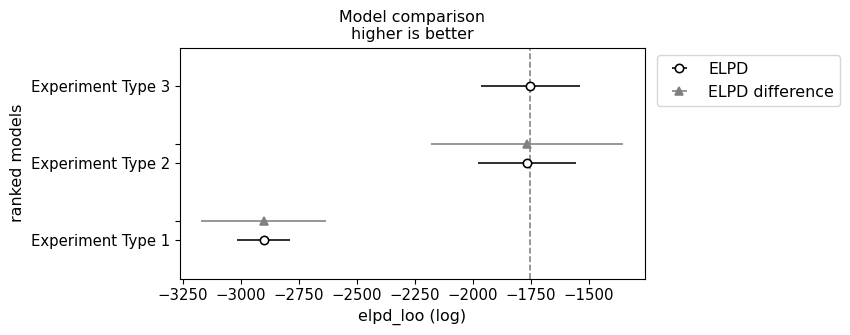

In [236]:
az.plot_compare(model_comparison)